In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, random_split

In [2]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = ta.utils.dropna(data)
df = ta.add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [34]:
def setlabel(row):
    return 1 if row['next_diff_curr'] >= 0 else 0

df['next_diff_curr'] = df['Close'].shift(-1) - df['Close']
df['label'] = df.apply(setlabel, axis=1)

df['feature_sma_diff'] = df['trend_sma_fast'] - df['trend_sma_slow']
df['feature_ema_diff'] = df['trend_ema_fast'] - df['trend_ema_slow']
df['feature_diff_bbl'] = df['Close'] - df['volatility_bbl']
df['feature_diff_bbh'] = df['volatility_bbh'] - df['Close']

In [35]:
df = df.drop(columns=['next_diff_curr'])
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volume_vwap', 'volatility_atr',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', '

In [51]:
cols = set(df.columns)
cols.remove('label')
cols = list(cols)
cols.append('label')

In [52]:
processed = df[cols]
processed = processed[84:]

In [53]:
class StockDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        raw = self.df.iloc[idx].values
        if type(idx) == int:
            raw = raw.reshape(1, -1)
        data = torch.tensor(raw[:, :-1], dtype=torch.float32)
        label = torch.tensor(raw[:, -1], dtype=torch.long)
        return data, label

In [54]:
chosen = processed
dataset = StockDataset(chosen)

In [55]:
train_data, valid_data = random_split(dataset, [len(dataset)*8//10, len(dataset) - len(dataset)*8//10])

In [56]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [57]:
class StockPredictor(nn.Module):

    def __init__(self, feature_size):
        super(StockPredictor, self).__init__()
        self.m1 = nn.Sequential(
            nn.Linear(feature_size, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, 128),
            nn.Sigmoid(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.m1(x)
        return out

In [58]:
verbose = False

def train(model, dataloader, criterion, optimizer, epoch):
    model.train()
    train_loss, correct = 0, 0

    for batch, (data, target) in enumerate(dataloader):
        output = model(data.squeeze(1))
        loss = criterion(output, target.squeeze(1))
        train_loss += loss.item()
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate accuracy
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        # debug printing
        if batch % 10 == 0 and verbose:
            print('Training Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(dataloader.dataset),
                100. * batch / len(dataloader), loss.item()
            ))

    train_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print(f'Epoch: {epoch}')
    print('Training set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)'.format(
        train_loss, correct, total, 100. * accuracy
    ))

    return (train_loss, accuracy)

def validate(dataloader, model, criterion):
    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.squeeze(1))
            valid_loss += criterion(output, target.squeeze(1)).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    valid_loss /= len(dataloader.dataset)
    total = len(dataloader.dataset) * batch_size
    accuracy = correct / total

    print('Validation set: Average loss: {:.4f}, Accuracy {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, total, 100. * accuracy
    ))

    return (valid_loss, accuracy)

def run(lr, epochs=40):
    print(f'Running for epoch={epochs}, lr={lr} ... ')

    model = StockPredictor(len(df.columns)-1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = StepLR(optimizer, step_size=1, gamma=0.7, verbose=True)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    for t in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, t)
        train_losses.append(train_loss)
        train_acc.append(train_accuracy)

        valid_loss, valid_accuracy = validate(valid_loader, model, criterion) 
        valid_losses.append(valid_loss)
        valid_acc.append(valid_accuracy)

#         scheduler.step()

    print('[done]')
    return (model, train_losses, valid_losses, train_acc, valid_acc)

In [59]:
model, train_losses, valid_losses, train_accs, valid_accs = run(lr=0.0001)

Running for epoch=40, lr=0.0001 ... 
Epoch: 0
Training set: Average loss: 0.0433, Accuracy 47719/88944 (54%)
Validation set: Average loss: 0.0432, Accuracy 11996/22240 (54%)

Epoch: 1
Training set: Average loss: 0.0431, Accuracy 48949/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 12000/22240 (54%)

Epoch: 2
Training set: Average loss: 0.0431, Accuracy 48949/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 12000/22240 (54%)

Epoch: 3
Training set: Average loss: 0.0431, Accuracy 48922/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 12002/22240 (54%)

Epoch: 4
Training set: Average loss: 0.0431, Accuracy 48949/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 11996/22240 (54%)

Epoch: 5
Training set: Average loss: 0.0431, Accuracy 48913/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 12004/22240 (54%)

Epoch: 6
Training set: Average loss: 0.0431, Accuracy 48897/88944 (55%)
Validation set: Average loss: 0.0432, Accuracy 12008/22240 (54%

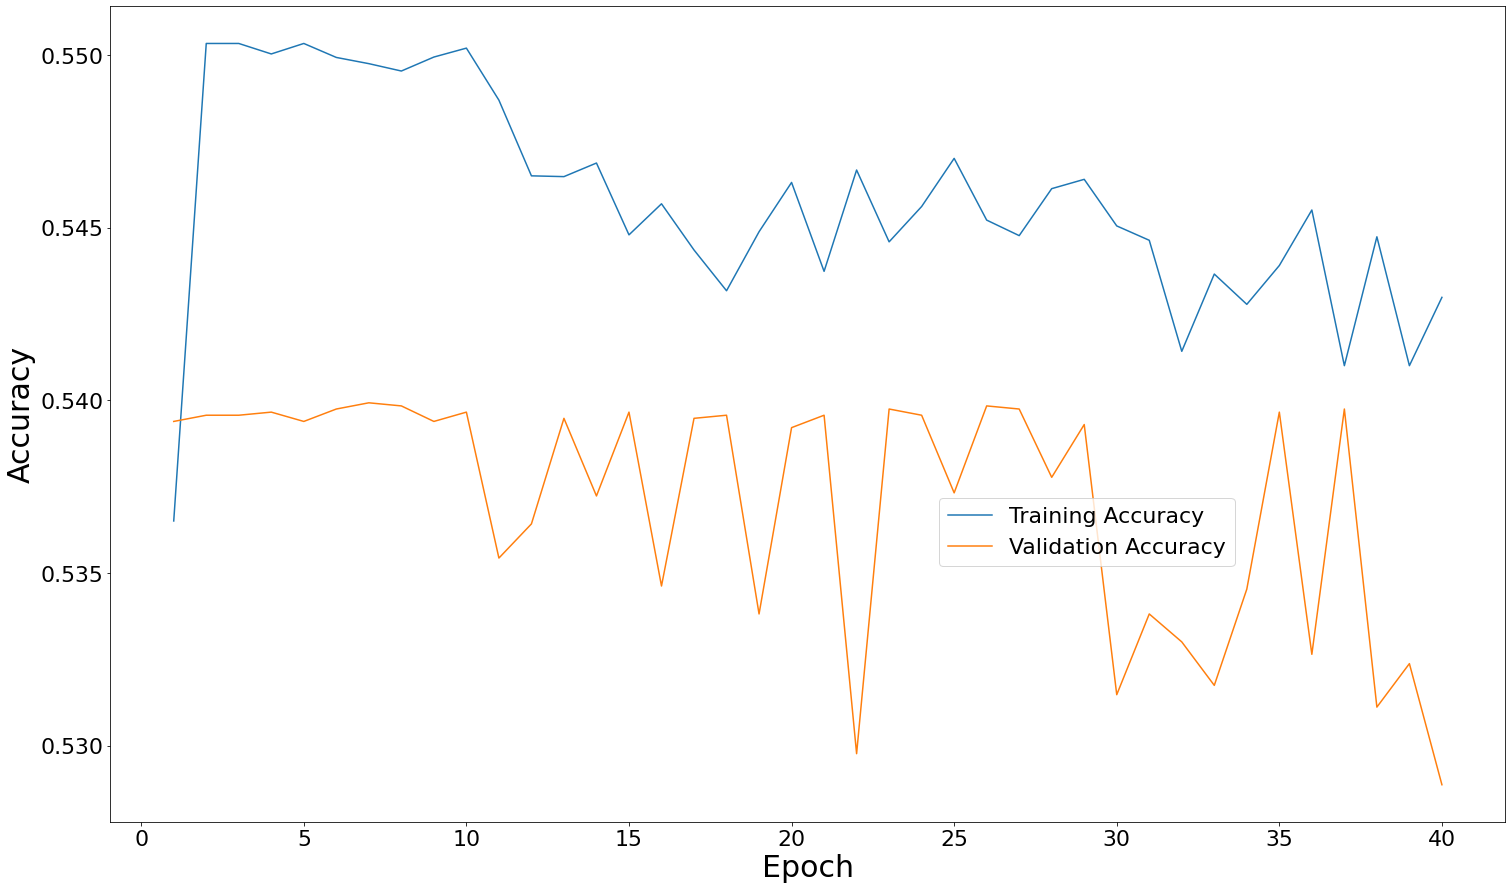

In [60]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_accs)+1))
plt.plot(epoches, train_accs, label='Training Accuracy')
plt.plot(epoches, valid_accs, label='Validation Accuracy')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.3), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.show()

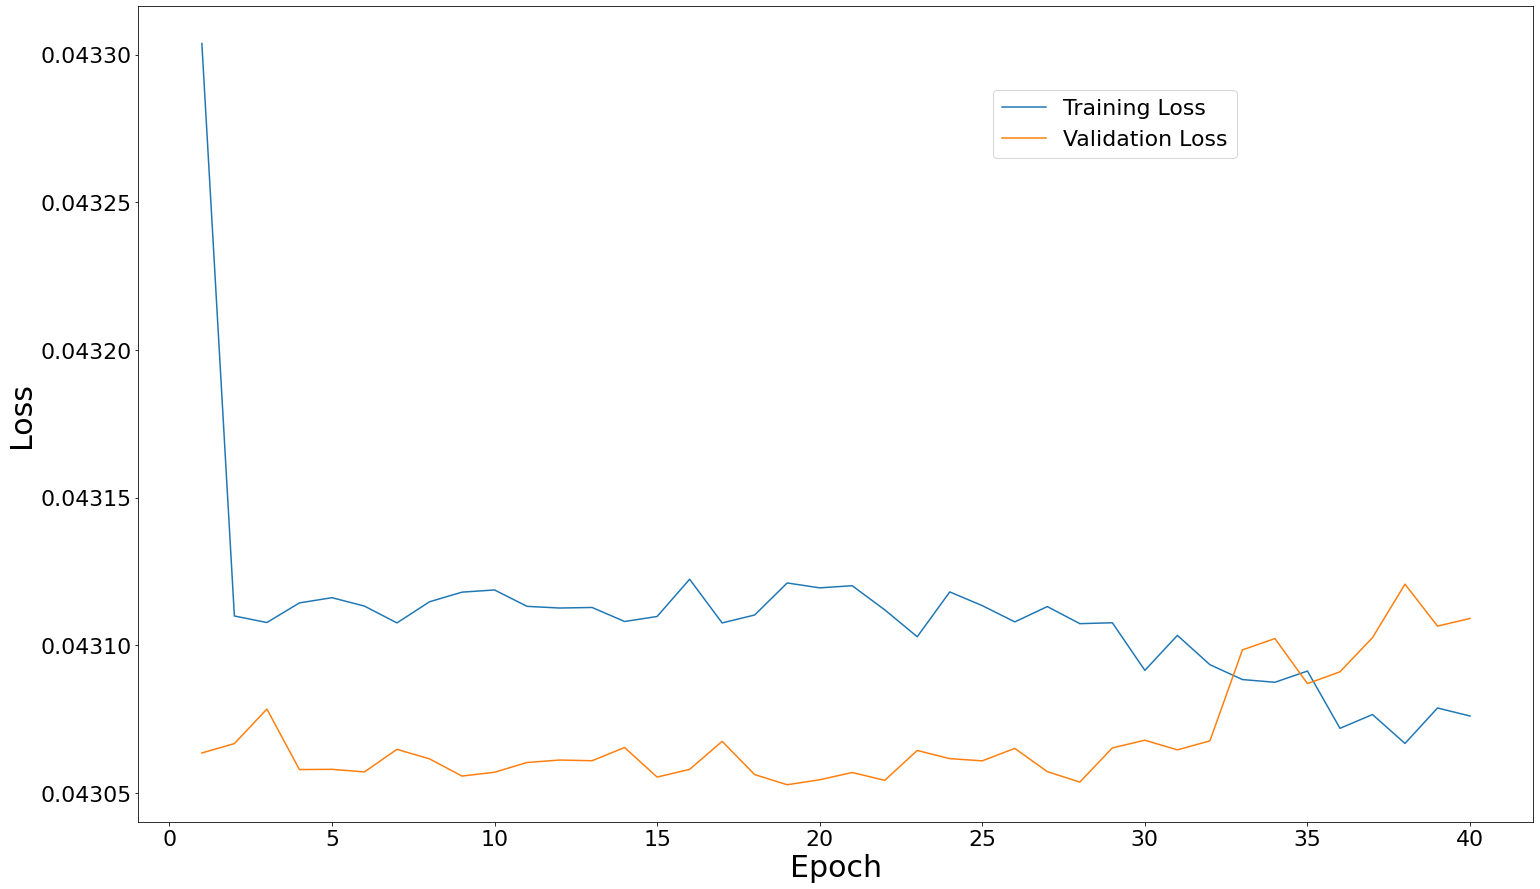

In [328]:
plt.figure(figsize=(25,15))

epoches = list(range(1,len(train_losses)+1))
plt.plot(epoches, train_losses, label='Training Loss')
plt.plot(epoches, valid_losses, label='Validation Loss')

plt.legend(loc='lower center', bbox_to_anchor=(0.7, 0.8), fontsize=22)
plt.xticks(range(0,41,5), fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Epoch', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.show()

In [62]:
model(torch.tensor(valid_data))

ValueError: only one element tensors can be converted to Python scalars

In [65]:
valid_data[0]

(tensor([[ 4.1491e+01,  4.1308e+01,  1.7148e+00,  9.6875e+01,  4.1176e+01,
           4.3526e+07,  4.0983e+01,  3.4098e+01,  3.4067e-01, -3.2000e+01,
          -4.1919e+01,  0.0000e+00, -2.6926e-01,  4.1645e+01,  3.9751e+01,
           2.1537e-01,  1.9415e+05,  5.2050e+01,  3.9273e+01,  4.0445e+01,
           0.0000e+00,  1.9914e-01,  1.6291e-01,  1.5861e+01,  9.5597e+01,
           1.4685e+02,  0.0000e+00,  6.4241e+01,  4.1871e+01,  1.0000e+00,
           3.7616e+00,  1.3245e-02,  9.6482e-01,  7.7752e-01, -2.2033e+03,
           4.2238e+01,  0.0000e+00,  4.0891e+01,  9.4793e-01,  4.0968e+01,
           3.0693e-01,  4.8298e+00,  2.4776e+01,  1.1182e+00,  7.6616e+00,
           3.1779e+07,  4.0891e+01,  6.3262e-01,  4.2378e+01,  4.1214e+01,
           2.5533e+00,  4.2099e+01,  4.0837e+01,  3.8420e+01, -9.8690e+00,
           2.6668e+01,  3.6000e+01,  4.0646e+01, -2.8491e-01,  4.0687e+01,
          -4.2804e-01,  4.0399e+01,  9.4541e-01,  3.7930e+00,  4.1286e+01,
           1.5090e+03, -5